In [10]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = pd.DataFrame()

data_path = r"data"
imaging_path = os.path.join(data_path, r"imaging_subset")
filenames = os.listdir(imaging_path)
depths = pd.read_csv(os.path.join(data_path, "depths.csv"))

for i in filenames:
    img = cv2.imread(os.path.join(imaging_path, i), 0)
    try:
        depth = depths[depths["Filenames"].str.lower() == i.lower()][
            "Depth from lung surface (in micrometers) where image was acquired"
        ].values[0]
        # some files are named with SK658 and some with Sk658
    except IndexError:
        print(f"couldn't find depth for file {i}")
        continue
    images = pd.concat(
        [images, pd.DataFrame([{"filename": i, "image": img, "depth": depth}])],
        ignore_index=True,
    )
slobe_images = images[images["filename"].str.contains("slobe", case=False)]
llobe_images = images[images["filename"].str.contains("llobe", case=False)]
print(images.shape)
print(slobe_images.shape)
print(llobe_images.shape)

(20, 3)
(10, 3)
(10, 3)


In [12]:
# read progress from csv
progress_path = os.path.join(data_path, "manual_contour_area.csv")
if os.path.exists(progress_path):
    progress = pd.read_csv(progress_path)
    labeled_files = progress["filename"].tolist()
    images = images[~images["filename"].isin(labeled_files)]
    print(f"Resuming from {len(labeled_files)} labeled files")
    print(f"{images.shape[0]} files remaining to label")
else:
    print("Starting fresh")
manual_contour_area = pd.DataFrame()

Starting fresh


# come back here to process another image

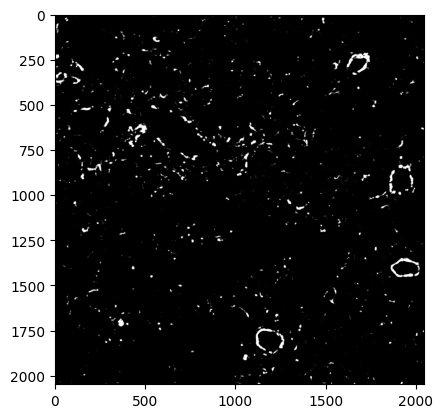

In [105]:
# one at a time: display image, plot contours to find areas, save to csv, remove from images

# display image on top of stack
orig_img = images.iloc[-1]["image"]
plt.imshow(orig_img, cmap="gray")
plt.show()

# reset updating_img
updating_img = orig_img.copy()

# remove small contours

areas of top 10 contours:
[26543.5, 20524.0, 15427.0, 14741.0, 9299.0, 7595.5, 7508.5, 6555.5]


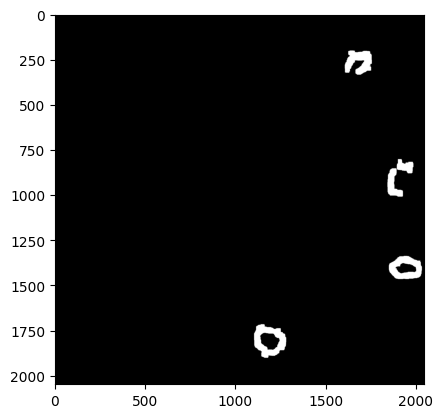

In [108]:
curr_img = orig_img.copy()
prev_img = updating_img.copy()
# work on updating img?
if input("Work on updating image? (y/n) ") == "y":
    curr_img = updating_img

# ensure the image is in grayscale before finding contours
if len(curr_img.shape) == 3:
    curr_img = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)

# remove small contours
contours, _ = cv2.findContours(
    curr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
print("areas of top 10 contours:")
areas = [cv2.contourArea(cntr) for cntr in contours]
areas.sort(reverse=True)
print(areas[:10])
cutoff_area = input("enter cutoff area for contours (default 1000): ")
try:
    cutoff_area = int(cutoff_area)
except: # default
    cutoff_area = 1000
for cntr in contours:
    if cv2.contourArea(cntr) > cutoff_area:
        continue
    convHull = cv2.convexHull(cntr)
    cv2.drawContours(
        curr_img, [convHull], -1, (0, 0, 0), thickness=cv2.FILLED
    )
curr_img = cv2.cvtColor(curr_img, cv2.COLOR_GRAY2RGB)
plt.imshow(curr_img)
plt.show()

updating_img = curr_img.copy()

# remove large contours

areas of top 10 contours:
[13598.5, 6458.0, 5773.0, 3566.5, 2954.0]


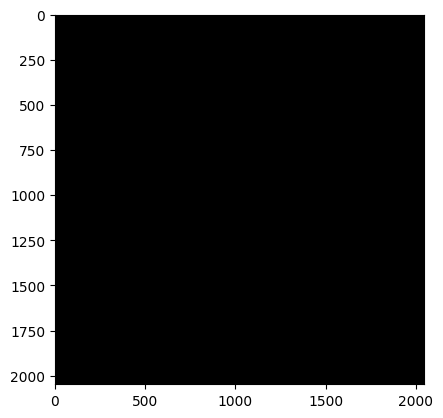

In [ ]:
prev_img = updating_img.copy()
curr_img = orig_img.copy()
# work on updating img?
if input("Work on updating image? (y/n) ") == "y":
    curr_img = updating_img

# ensure the image is in grayscale before finding contours
if len(curr_img.shape) == 3:
    curr_img = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)

# remove large contours
contours, _ = cv2.findContours(curr_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("areas of top 10 contours:")
areas = [cv2.contourArea(cntr) for cntr in contours]
areas.sort(reverse=True)
print(areas[:10])
cutoff_area = input("enter cutoff area for contours (default 1000): ")
try:
    cutoff_area = int(cutoff_area)
except:  # default
    cutoff_area = 1000
for cntr in contours:
    if cv2.contourArea(cntr) < cutoff_area:
        continue
    convHull = cv2.convexHull(cntr)
    cv2.drawContours(curr_img, [convHull], -1, (0, 0, 0), thickness=cv2.FILLED)
curr_img = cv2.cvtColor(curr_img, cv2.COLOR_GRAY2RGB)
plt.imshow(curr_img)
plt.show()

updating_img = curr_img.copy()

# dilate

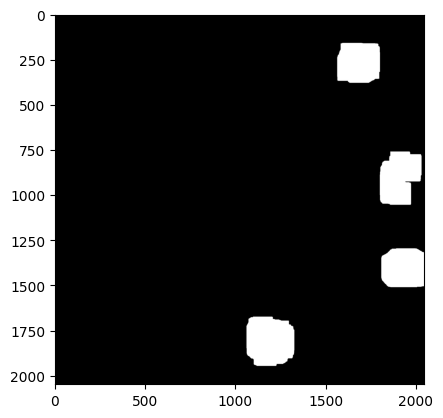

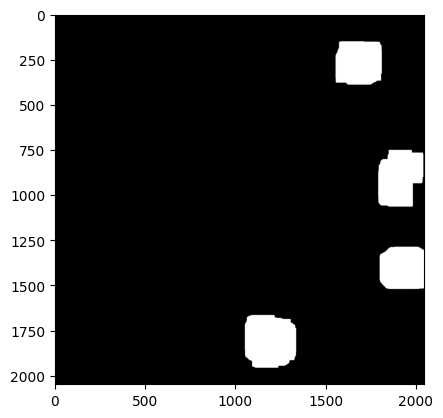

In [117]:
prev_img = updating_img.copy()
curr_img = curr_img.copy()
if input("Work on updating image for dilation? (y/n) ") == "y":
    curr_img = updating_img

plt.imshow(curr_img, cmap="gray")
plt.show()

dilate_size = input("Enter kernel size for dilation (default 15): ")
try:
    dilate_size = int(dilate_size)
except:
    dilate_size = 15

img_dilate = cv2.dilate(curr_img, np.ones((dilate_size, dilate_size), np.uint8), iterations=1)
updating_img = img_dilate.copy()
plt.imshow(img_dilate, cmap="gray")
plt.show()

# erode

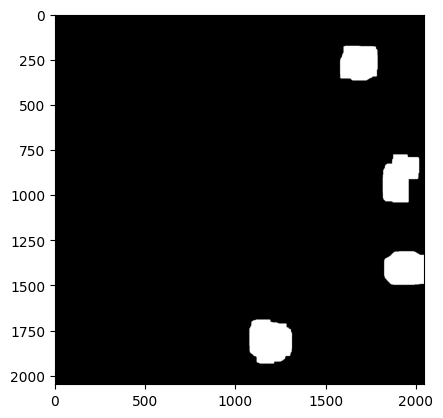

In [122]:
prev_img = updating_img.copy()
curr_img = img_dilate.copy()
if input("Work on updating image for erosion? (y/n) ") == "y":
    curr_img = updating_img


erode_size = input("Enter kernel size for erosion (default 15): ")
try:
    erode_size = int(erode_size)
except:
    erode_size = 15

curr_img = cv2.erode(curr_img, np.ones((erode_size, erode_size), np.uint8), iterations=1)
plt.imshow(curr_img, cmap="gray")
plt.show()
updating_img = curr_img.copy()

# check progress

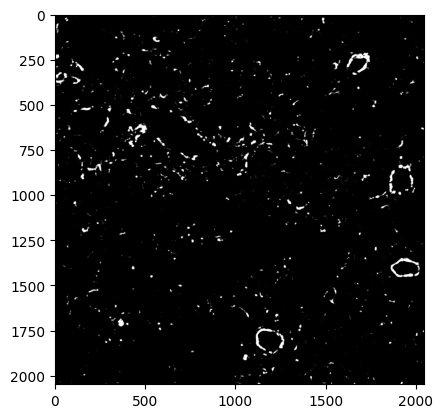

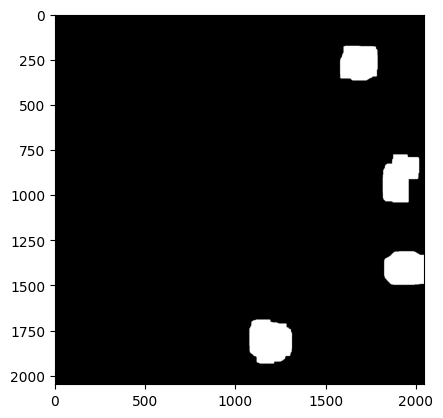

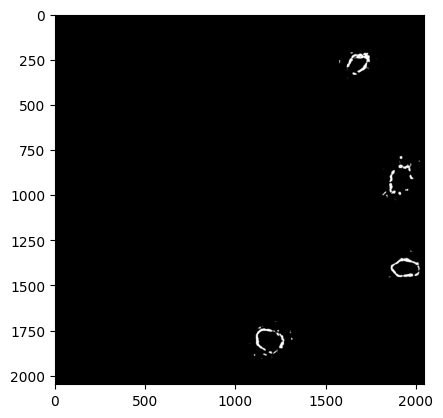

In [123]:
plt.imshow(orig_img, cmap="gray")
plt.show()

plt.imshow(updating_img)
plt.show()

# mask original image with updating_img
masked_orig = cv2.bitwise_and(orig_img, orig_img, mask=cv2.cvtColor(updating_img, cv2.COLOR_RGB2GRAY))
plt.imshow(masked_orig, cmap="gray")
plt.show()

# undo

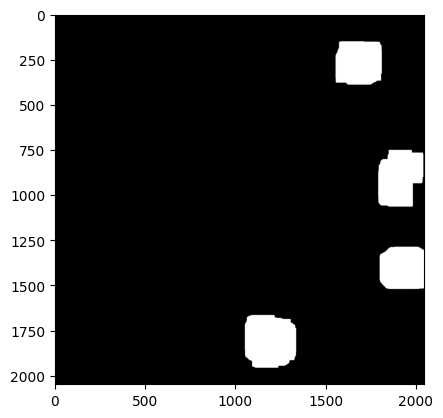

In [119]:
updating_img = prev_img.copy()
plt.imshow(updating_img)
plt.show()

# save progress to csv, remove processed image

In [124]:
area = np.sum(updating_img > 0)
print(f"Area: {area} pixels")
manual_contour_area = pd.read_csv(progress_path) if os.path.exists(progress_path) else pd.DataFrame(columns=["filename", "depth", "area_pixels"])
manual_contour_area = pd.concat(
    [
        manual_contour_area,
        pd.DataFrame(
            [
                {
                    "filename": images.iloc[-1]["filename"],
                    "depth": images.iloc[-1]["depth"],
                    "area_pixels": area,
                }
            ]
        ),
    ], ignore_index=True,
)
manual_contour_area.to_csv(progress_path, index=False)
images = images.iloc[:-1]
print(f"{images.shape[0]} files remaining to label")

Area: 529614 pixels
16 files remaining to label
